In [40]:
import django
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from twitter.models import *
import parliament.models as pms
import scoping.models as sms

from django.utils.dateparse import parse_datetime

from django.db.models import Sum, Count
from django.db.models.fields import DateField
from django.db.models.functions import Cast
import textwrap as tw
import datetime
p = sms.Project.objects.get(pk=134)

In [35]:
Status.objects.filter(text__icontains="kohle").count()

227543

In [30]:
s = Status.objects.filter(
    text__icontains="kohle",
    author__monitoring=True,
    author__person__isnull=True
).exclude(
    text__iregex="Kohler\W"
)
ats = s.values('author__name').annotate(
    n = Count('pk')
).order_by('-n')

kommission = set(s.distinct('author__id').values_list('author__id',flat=True))
kommission = User.objects.filter(id__in=kommission)

kommission.count()

34

In [32]:
df = pd.DataFrame.from_dict(list(ats))
df.head(30)

,author__name,n
0,Initiative Buirer für Buir,1078
1,Martin Kaiser,373
2,Hubert Weiger,369
3,BUND,323
4,IG BCE,199
5,Barbara Praetorius,90
6,Felix Chr. Matthes,69
7,Öko-Institut e.V.,69
8,DNR,68
9,Christine Herntier,63


In [33]:
s = Status.objects.filter(
    text__icontains="kohle",
)

ats = s.values('author__name').annotate(
    n = Count('pk')
).order_by('-n')

df = pd.DataFrame.from_dict(list(ats))
df.head(30)


,author__name,n
0,,2992
1,Initiative Buirer für Buir,1078
2,Ende Gelände,536
3,o je 🧡,519
4,Kohle-Protest,508
5,"Dr. Julia Verlinden, MdB",466
6,Heiko Stubner,458
7,Fossil Free Berlin,374
8,Martin Kaiser,373
9,Hubert Weiger,369


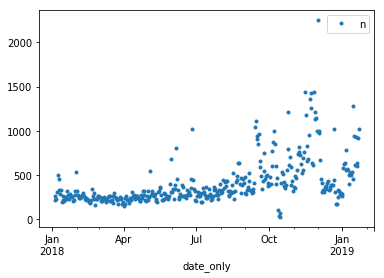

In [39]:
midnight = django.utils.timezone.make_aware(datetime.datetime.now().replace(hour=0,minute=0)) 

cutoff1 = midnight - timedelta(days=16)

cutoff2 = midnight - timedelta(days=400)

byday = s.filter(created_at__lt=cutoff1,created_at__gt=cutoff2).annotate(
    date_only=Cast('created_at', DateField())
).values('date_only').annotate(
    n = Count('pk')
).order_by('date_only')

df = pd.DataFrame.from_dict(list(byday))

df.head()

df['date_only'] = pd.to_datetime(df['date_only'])

df.plot('date_only','n', style=".")

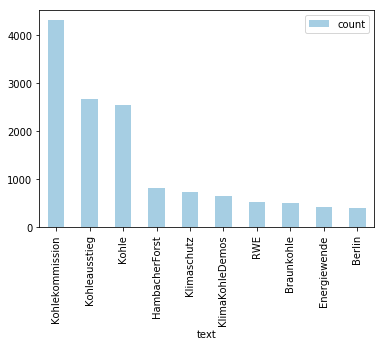

In [51]:
month = 11
cutoff1 = parse_datetime(f'2018-{month}-01T00:00:00+0000')
cutoff2 = cutoff1 + timedelta(days=30)

ttweets = Status.objects.filter(
    text__icontains="kohle",
    created_at__gt=cutoff1,
    created_at__lt=cutoff2
)

hts = []
for s in ttweets.filter(entities__hashtags__iregex='\w'):
    for hashtag in s.entities['hashtags']:
        try:
            ht = [x for x in hts if x['text']==hashtag['text']][0]
            ht['count']+=1
        except:
            ht = {"text": hashtag["text"], "count": 1}
            hts.append(ht) 
  
fig, ax = plt.subplots()

ht_df = df.from_dict(hts)
ht_df = ht_df.sort_values('count',ascending=False).head(10)
ht_df.plot.bar('text','count',colormap='Paired',ax = ax)

plt.show()

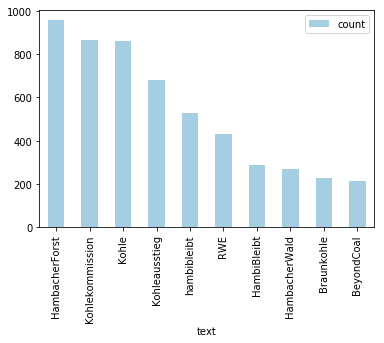

In [52]:
month = 10
cutoff1 = parse_datetime(f'2018-{month}-01T00:00:00+0000')
cutoff2 = cutoff1 + timedelta(days=30)

ttweets = Status.objects.filter(
    text__icontains="kohle",
    created_at__gt=cutoff1,
    created_at__lt=cutoff2
)

hts = []
for s in ttweets.filter(entities__hashtags__iregex='\w'):
    for hashtag in s.entities['hashtags']:
        try:
            ht = [x for x in hts if x['text']==hashtag['text']][0]
            ht['count']+=1
        except:
            ht = {"text": hashtag["text"], "count": 1}
            hts.append(ht) 
  
fig, ax = plt.subplots()

ht_df = df.from_dict(hts)
ht_df = ht_df.sort_values('count',ascending=False).head(10)
ht_df.plot.bar('text','count',colormap='Paired',ax = ax)

plt.show()

In [95]:
ttweets = set(Status.objects.filter(
    text__icontains="kohle"
).values_list('id',flat=True))

texts = Status.objects.filter(
    id__in=random.sample(ttweets, 20000)
).values_list('text',flat=True)

from parliament.tasks import * 
stemmer = SnowballStemmer("german")
tokenizer = german_stemmer()
stopword_list = [stemmer.stem(t) for t in stopwords.words("german")]


vectorizer = CountVectorizer(max_df=0.8,
                             min_df=5,
                             max_features=10000,
                             tokenizer=tokenizer,
                             stop_words=stopword_list)

dtm = vectorizer.fit_transform(texts)

/home/galm/software/django/tmvenv_36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gew'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [96]:
K = 20

model = NMF(
    n_components=K, random_state=1,
    alpha=0.1, l1_ratio=.1,
    init='nndsvd'
).fit(dtm)

dtm = model.transform(dtm)

In [97]:
tfidf_feature_names = vectorizer.get_feature_names()
def display_topics(model, feature_names, no_top_words, dtm, texts):
    for topic_idx, topic in enumerate(model.components_):
        tdocs = dtm[:,topic_idx]
        print(f"\n###Topic {topic_idx}")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("\n")
        print("\n\n".join([texts[i]
                        for i in tdocs.argsort()[:-no_top_words - 1:-1]]))
        
        
no_top_words = 10
display_topics(model, tfidf_feature_names, no_top_words, dtm, list(texts))


###Topic 0
kohl raus gas genug bekomm kommt halt strom einfach macht


Kohle, Kohle, Kohle, nicht Klimawandel, Kohle, Leute! Kohle, Kohle, Kohle! Kohle ist Würde! https://t.co/eYax5A237g

#Kohle? Mir fällt zu dem Twittertrend irgendwie nur "Kohle Kohle Kohle, Kohle Kohle, trallala, Kohle Kohle, hopsassa..." ein. :D

Kohle Kohle Kohle.
Kohle Kohle Kohle. https://t.co/som5TTNyy6

Kohle Kohle Kohle 
Kohle Kohle Kohle

@KompetenzSimba @VeriPBM

Gronkhi Gronkhi Gronkh Gronkhi Gronkhi Gronkh
( Kohle Kohle Kohle Kohle Kohle Kohle)🎵

Kohle Kohle Kohle, Kohle Kohle Tralalaa

@NettieMau @ChanMachtSo Kohle Kohle Kooohle Kohle Kohle Kohle

@faz_donalphonso @luebberding Der geeignete Mann für Frauen braucht vor allem eins: Kohle, Kohle, Kohle, Kohle .....

RWE feiert heute den Tag der Biodiversität: Kohle aus Hambach – Kohle aus Inden – Kohle aus Garzweiler… Ist doch alles Bio ist doch alles Kohle. 
Wir würden RWE richtig feiern, wenn sie den Tag der Biodiversität nutzen und verkünden würden, dass

In [110]:
ttweets = set(Status.objects.filter(
    text__icontains="kohle",
    author__monitoring=True
).values_list('id',flat=True))

texts = Status.objects.filter(
    id__in=ttweets
).values_list('text',flat=True)

from parliament.tasks import * 
stemmer = SnowballStemmer("german")
tokenizer = german_stemmer()
stopword_list = [stemmer.stem(t) for t in stopwords.words("german")]


vectorizer = CountVectorizer(max_df=0.8,
                             min_df=5,
                             max_features=10000,
                             tokenizer=tokenizer,
                             stop_words=stopword_list)

tfidf = vectorizer.fit_transform(texts)

tfidf.shape

/home/galm/software/django/tmvenv_36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gew'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(7280, 2398)

In [113]:
K = 20

model = NMF(
    n_components=K, random_state=1,
    alpha=0.1, l1_ratio=.1,
    init='nndsvd'
).fit(tfidf)

dtm = model.transform(tfidf)

tfidf_feature_names = vectorizer.get_feature_names()
def display_topics(model, feature_names, no_top_words, dtm, texts):
    for topic_idx, topic in enumerate(model.components_):
        tdocs = dtm[:,topic_idx]
        print(f"\n##############################################\n### Topic {topic_idx}")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("\n")
        print("\n\n".join([texts[i]
                        for i in tdocs.argsort()[:-5 - 1:-1]]))
        
        
no_top_words = 10
display_topics(model, tfidf_feature_names, no_top_words, dtm, list(texts))


##############################################
### Topic 0
kohleausstieg grun diegru kommt einleit groko fdpbt klimakris wichtig klimaziel


#deutscherEnergiekongress: #Kohleausstieg bis 2030 versorgungssicher möglich &amp;führt nicht zu steigenden Strompreisen, so @P_Graichen v @AgoraEW.
Aber dafür brauchts politische Entscheidungen, passiert nicht von allein.
Übrigens beschließen viele europäische Staaten Kohleausstieg. https://t.co/43jBomAQOR

@FrankSchwabe @Oliver_Krischer @Die_Gruenen Sorry Frank, aber 7GW?! Das wäre der Einstieg in d Kohleausstieg, das weißt du genau. Ohne gesetzliche Regelung zum #Kohleausstieg bringt ein CO2 Preis nicht viel. Zumal der in der #Groko Endfassung ja so gut wie raus ist &amp; Klimaschutzgesetz ohne 2020 Ziel ist ebenso Placebo.

Je früher der Kohleausstieg kommt, desto besser. Aber anstatt eines "radikalen" Ausstiegs wie die Grünen fordern, plädieren wir für einen sozialverträglichen  Ausstieg für die Beschäftigten und ihre Familien.
#SPD #garanti